In [1]:
import os
from glob import glob
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_path = "/userhome/student/bial/neural-punctuator/models/"
model_names = ["bert-base-uncased", "bert-base-cased", "albert-unfreezed"]
plt_names = ["bert-base-uncased", "bert-base-cased", "albert-base-v1"]

In [3]:
files = {}
for model_name in model_names:
    f = sorted(glob(data_path + f"{model_name}-epoch*.*"), key=os.path.getmtime)
    files[model_name] = f
files

{'bert-base-uncased': ['/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-1.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-2.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-3.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-4.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-5.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-6.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-7.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-8.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-9.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-10.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-uncased-epoch-11.pth',
  '/userhome/student/bial/neural-punctuator/models/bert-base-unc

In [4]:
def load_scores(model_path):
    checkpoint = torch.load(model_path)
    return checkpoint['metrics']

In [80]:
# metrics = {}
# for model_name in model_names:
#     m = []
#     for file in tqdm(files[model_name]):
#         m.append(load_scores(file))
#     metrics[model_name] = m
    
# with open('metrics.pkl', 'wb') as f:
#     pickle.dump(metrics, f)
    
with open('metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)

In [110]:
def get_strict_f_score(report):
    return sum(float(report['cls_report'][output]['f1-score']) for output in ('period', 'question', 'comma')) / 3
    
for _, m in metrics.items():
    for epoch in m:
        epoch['strict_f_score'] = get_strict_f_score(epoch)

In [111]:
metrics['bert-base-uncased'][0]

{'cls_report': {'empty': {'precision': 0.9883400466398135,
   'recall': 0.9630241685602148,
   'f1-score': 0.9755178907721279,
   'support': 14523},
  'period': {'precision': 0.7442827442827443,
   'recall': 0.8325581395348837,
   'f1-score': 0.7859495060373216,
   'support': 860},
  'question': {'precision': 0.6533333333333333,
   'recall': 0.6901408450704225,
   'f1-score': 0.6712328767123288,
   'support': 71},
  'comma': {'precision': 0.6015299026425591,
   'recall': 0.7380546075085325,
   'f1-score': 0.6628352490421456,
   'support': 1172},
  'accuracy': 0.9392517743293637,
  'macro avg': {'precision': 0.7468715067246126,
   'recall': 0.8059444401685133,
   'f1-score': 0.7738838806409809,
   'support': 16626},
  'weighted avg': {'precision': 0.9470182467218163,
   'recall': 0.9392517743293637,
   'f1-score': 0.9423711866353711,
   'support': 16626}},
 'precision': 0.7468715067246126,
 'recall': 0.8059444401685133,
 'f_score': 0.7738838806409809,
 'auc': 0.9549497090088623,
 'loss'

In [112]:
def best_epoch_by_f_score(metrics):
    best_score = metrics[0]['strict_f_score']
    best_epoch = 0
    for i, m in enumerate(metrics):
        if m['strict_f_score'] > best_score:
            best_score = m['strict_f_score']
            best_epoch = i
    return best_epoch, best_score

In [113]:
def best_epoch_by_loss(metrics):
    best_loss = metrics[0]['loss']
    best_epoch = 0
    for i, m in enumerate(metrics):
        if m['loss'] < best_loss:
            best_loss = m['loss']
            best_epoch = i
    return best_epoch, best_loss

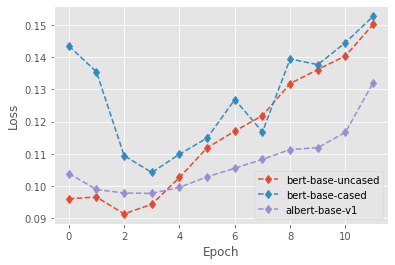

In [146]:
plt.style.use('ggplot')
# plt.title('Valid loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
for model_name, m in metrics.items():
    loss = [float(epoch['loss']) for epoch in m ]
    plt.plot(loss, '--d')
plt.legend(plt_names)
plt.savefig('imgs/valid_loss.svg')
plt.show()

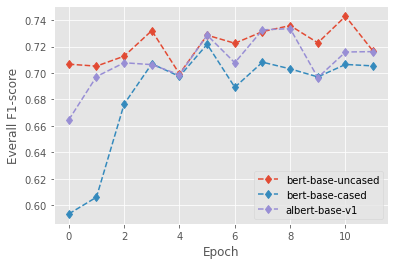

In [147]:
plt.style.use('ggplot')
# plt.title('Valid F1-score')
plt.ylabel('Everall F1-score')
plt.xlabel('Epoch')
for model_name, m in metrics.items():
    loss = [float(epoch['strict_f_score']) for epoch in m ]
    plt.plot(loss, '--d')
plt.legend(plt_names)
plt.savefig('imgs/valid_f1_score.svg')
plt.show()

In [116]:
for model_name, m in metrics.items():
    print(f"{model_name}:\n" + 
          f"F1-score: {best_epoch_by_f_score(m)}\n" + 
          f"Loss: {best_epoch_by_loss(m)}\n")

bert-base-uncased:
F1-score: (10, 0.7429548325909643)
Loss: (2, 0.09127800828880733)

bert-base-cased:
F1-score: (5, 0.7217123138175771)
Loss: (3, 0.1041829191148281)

albert-unfreezed:
F1-score: (8, 0.7335936794934502)
Loss: (3, 0.09766033457385169)



# Multiple predictions

In [13]:
from neural_punctuator.utils.data import get_config_from_yaml
from neural_punctuator.models.BertPunctuator import BertPunctuator

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from neural_punctuator.data.dataloader import BertDataset, collate, get_data_loaders, get_datasets
from neural_punctuator.models.BertPunctuator import BertPunctuator
from torch.optim import AdamW
from torch import nn

from neural_punctuator.utils.io import save, load
from neural_punctuator.utils.metrics import get_total_grad_norm, get_eval_metrics
import numpy as np
import pickle

from torch.utils.data import Dataset, DataLoader

In [152]:
from itertools import product

for model_name, model_type in product(model_names, ('by_loss', 'by_f_score')):
     print(model_name, model_type)

bert-base-uncased by_loss
bert-base-uncased by_f_score
bert-base-cased by_loss
bert-base-cased by_f_score
albert-unfreezed by_loss
albert-unfreezed by_f_score


In [121]:
model_name = 'bert-base-uncased'
model_type = 'by_f_score'
if model_type == 'by_f_score':
    epoch, _ = best_epoch_by_f_score(metrics[model_name])
elif model_type == 'by_loss':
    epoch, _ = best_epoch_by_loss(metrics[model_name])
else:
    raise ValueError("Model type not valid, options: by_f_score/by_loss")
epoch

10

In [122]:
config = get_config_from_yaml(f'neural_punctuator/configs/config-{model_name}-unfreeze.yaml')
config.trainer.load_model = f"{model_name}-epoch-{epoch+1}.pth"

In [123]:
config.trainer.load_model, config.model.save_model_path

('bert-base-uncased-epoch-11.pth',
 '/userhome/student/bial/neural-punctuator/models/')

In [124]:
device = torch.device('cuda:0')
torch.cuda.set_device(device)

model = BertPunctuator(config)
model.to(device)

load(model, None, config)

In [125]:
config.model.predict_step = 1 

class BertDataset(Dataset):
    def __init__(self, prefix, config, is_train=False):

        self.config = config
        self.is_train = is_train

        with open(config.data.data_path + prefix + "_data.pkl", 'rb') as f:
            texts, targets = pickle.load(f)
            self.encoded_texts = [word for t in texts for word in t]
            self.targets = [t for ts in targets for t in ts]

    def __getitem__(self, idx):
        if self.is_train:
            shift = np.random.randint(self.config.trainer.seq_shift) - self.config.trainer.seq_shift // 2
        else:
            shift = 0

        start_idx = idx * config.model.predict_step + shift
        start_idx = max(0, start_idx)
        end_idx = start_idx + self.config.model.seq_len
        return torch.LongTensor(self.encoded_texts[start_idx: end_idx]),\
               torch.LongTensor(self.targets[start_idx: end_idx])

    def __len__(self):
        return (len(self.encoded_texts)-self.config.model.seq_len)//config.model.predict_step + 1


In [126]:
valid_dataset = BertDataset("valid", config)
len(valid_dataset)

18734

In [127]:
valid_dataset[0][0][:20], valid_dataset[1][0][:20]

(tensor([  101,  2017,  2113,  2028,  1997,  1996,  6387, 26552,  1997,  3604,
          1998,  2028,  1997,  1996, 12208,  2015,  1997,  3802,  7295, 13705]),
 tensor([ 2017,  2113,  2028,  1997,  1996,  6387, 26552,  1997,  3604,  1998,
          2028,  1997,  1996, 12208,  2015,  1997,  3802,  7295, 13705,  2470]))

In [128]:
config.predict.batch_size = 128
valid_loader = DataLoader(valid_dataset, batch_size=config.predict.batch_size, collate_fn=collate)

In [129]:
model.eval()
all_valid_preds = []

for data in tqdm(valid_loader):
    text, targets = data
    with torch.no_grad():
        preds, _ = model(text.to(device))

    all_valid_preds.append(preds.detach().cpu().numpy())

100%|██████████| 147/147 [08:55<00:00,  3.64s/it]


In [130]:
with open("all_valid_preds.pkl", "wb") as f:
    pickle.dump(all_valid_preds, f)

# with open("all_valid_preds.pkl", "rb") as f:
#     all_valid_preds = pickle.load(f)

In [131]:
all_valid_target = valid_dataset.targets
len(all_valid_target)

19245

In [132]:
len(all_valid_preds), all_valid_preds[0].shape

(147, (128, 512, 4))

In [133]:
all_valid_preds = np.concatenate(all_valid_preds)
all_valid_preds.shape

(18734, 512, 4)

In [134]:
config.model.seq_len, config.model.predict_step

(512, 1)

In [135]:
pred_num = config.model.seq_len // config.model.predict_step
pred_num

512

In [136]:
all_targets = []
all_preds = []

for i in tqdm(range(0, all_valid_preds.shape[0]//pred_num)):
    targets = all_valid_target[i*config.model.seq_len: (i+1)*config.model.seq_len]
    
    preds = all_valid_preds[i*pred_num]
    
    all_targets.append(targets)
    all_preds.append(preds)

100%|██████████| 36/36 [00:00<00:00, 29670.85it/s]


In [137]:
targets = np.concatenate(all_targets)
preds = np.concatenate(all_preds)

targets.shape, preds.shape

((18432,), (18432, 4))

(array([16022.,     0.,     0.,   892.,     0.,     0.,    69.,     0.,
            0.,  1449.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

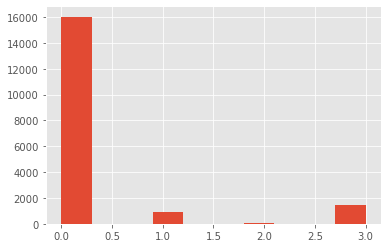

In [138]:
plt.hist(preds.argmax(-1))

In [139]:
preds = preds[targets != -1]
targets = targets[targets != -1]

preds.shape, targets.shape

((16626, 4), (16626,))

In [140]:
all_valid_preds.shape, len(all_valid_target), pred_num

((18734, 512, 4), 19245, 512)

In [141]:
pred_count = all_valid_preds.shape[0]
pred_count

18734

In [142]:
def combine(pred_num):

    relevant_preds = all_valid_preds[::pred_num]

    ps = []

    for i in range(relevant_preds.shape[0]):#+512//pred_num-1):
    #     ps.append(relevant_preds[i, :pred_num])


        start_idx = max(0, i-512//pred_num+1)
        end_idx = min(relevant_preds.shape[0], i+1)

        p = []
        for j, k in enumerate(range(start_idx, end_idx)):
            j = end_idx - start_idx - j - 1
    #         print(k, j, relevant_preds[k][j*pred_num:(j+1)*pred_num].mean())
            p.append(relevant_preds[k][j*pred_num:(j+1)*pred_num])
    #     print()
        p = np.stack(p)
        
        if p.shape[0] > 2:
            p = p[1:-1, :, :]
            
        ps.append(np.log(np.exp(p).mean(0)))

    ps = np.concatenate(ps)
    
    return ps
ps = combine(pred_num)

              precision    recall  f1-score   support

       empty      0.989     0.969     0.979     14740
      period      0.797     0.817     0.807       882
    question      0.761     0.718     0.739        71
       comma      0.626     0.769     0.690      1194

    accuracy                          0.946     16887
   macro avg      0.793     0.818     0.804     16887
weighted avg      0.952     0.946     0.948     16887

2020-11-18 22:49:29,169 INFO      Macro precision is: 0.7931083398261503
2020-11-18 22:49:29,172 INFO      Macro recall is 0.8184534637449834
2020-11-18 22:49:29,176 INFO      Macro f-score is 0.8037327633272642
2020-11-18 22:49:29,195 INFO      AUC is: 0.9606644655368516
2020-11-18 22:49:29,236 INFO      Plotting confusion matrix without normalization


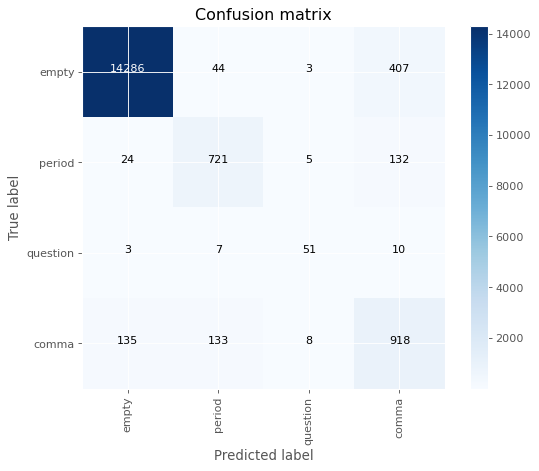

1 0.7453452056094371
              precision    recall  f1-score   support

       empty      0.989     0.969     0.979     14740
      period      0.798     0.817     0.807       882
    question      0.765     0.732     0.748        71
       comma      0.626     0.770     0.691      1194

    accuracy                          0.946     16887
   macro avg      0.794     0.822     0.806     16887
weighted avg      0.952     0.946     0.949     16887

2020-11-18 22:49:32,858 INFO      Macro precision is: 0.7943943444014097
2020-11-18 22:49:32,862 INFO      Macro recall is 0.8222009313913416
2020-11-18 22:49:32,865 INFO      Macro f-score is 0.8063184973453631
2020-11-18 22:49:32,884 INFO      AUC is: 0.9608926976474393
2020-11-18 22:49:32,926 INFO      Plotting confusion matrix without normalization


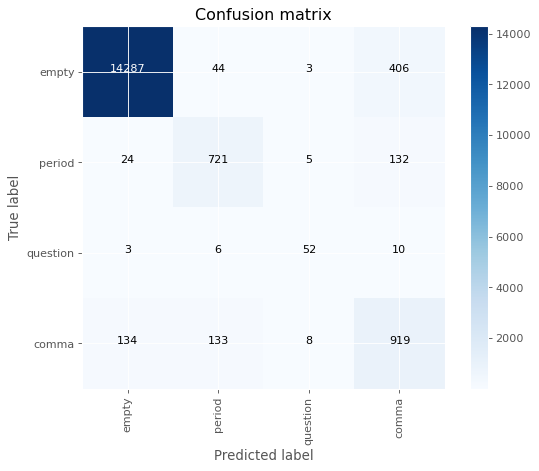

2 0.7487700105301932
              precision    recall  f1-score   support

       empty      0.989     0.969     0.979     14742
      period      0.797     0.817     0.807       882
    question      0.761     0.718     0.739        71
       comma      0.627     0.771     0.691      1194

    accuracy                          0.946     16889
   macro avg      0.793     0.819     0.804     16889
weighted avg      0.952     0.946     0.949     16889

2020-11-18 22:49:34,043 INFO      Macro precision is: 0.7933771698279086
2020-11-18 22:49:34,047 INFO      Macro recall is 0.8188902272170727
2020-11-18 22:49:34,050 INFO      Macro f-score is 0.8040698580894285
2020-11-18 22:49:34,068 INFO      AUC is: 0.9614646473448315
2020-11-18 22:49:34,109 INFO      Plotting confusion matrix without normalization


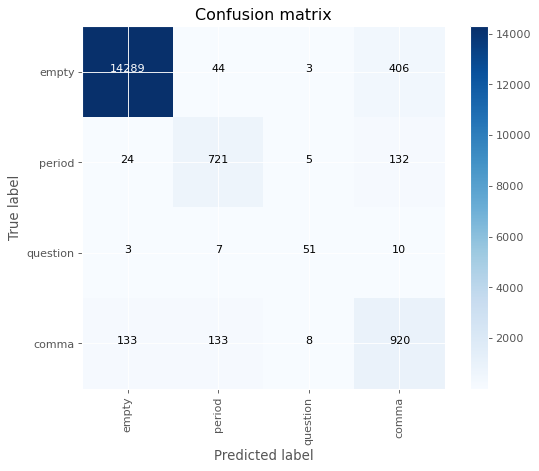

4 0.7457596851764133
              precision    recall  f1-score   support

       empty      0.989     0.969     0.979     14742
      period      0.800     0.819     0.809       882
    question      0.754     0.732     0.743        71
       comma      0.628     0.771     0.692      1194

    accuracy                          0.946     16889
   macro avg      0.792     0.823     0.806     16889
weighted avg      0.953     0.946     0.949     16889

2020-11-18 22:49:34,539 INFO      Macro precision is: 0.7924165758207102
2020-11-18 22:49:34,543 INFO      Macro recall is 0.8227287173902376
2020-11-18 22:49:34,546 INFO      Macro f-score is 0.8056550941693792
2020-11-18 22:49:34,564 INFO      AUC is: 0.9617796533273886
2020-11-18 22:49:34,605 INFO      Plotting confusion matrix without normalization


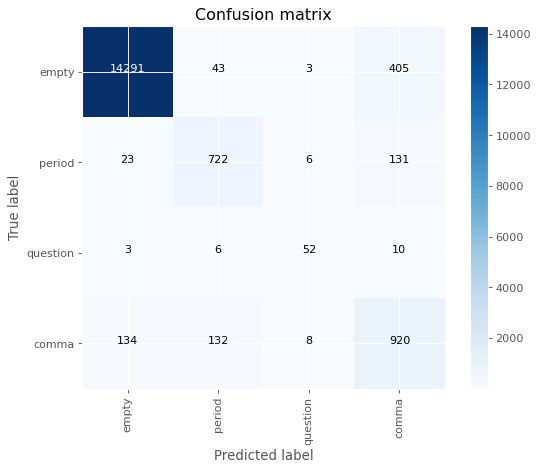

8 0.7478500171998624
              precision    recall  f1-score   support

       empty      0.989     0.969     0.979     14742
      period      0.800     0.819     0.809       882
    question      0.746     0.746     0.746        71
       comma      0.625     0.769     0.690      1194

    accuracy                          0.946     16889
   macro avg      0.790     0.826     0.806     16889
weighted avg      0.952     0.946     0.949     16889

2020-11-18 22:49:34,850 INFO      Macro precision is: 0.790262576772451
2020-11-18 22:49:34,854 INFO      Macro recall is 0.8257462919303309
2020-11-18 22:49:34,857 INFO      Macro f-score is 0.8061078166761387
2020-11-18 22:49:34,875 INFO      AUC is: 0.9618717763254613
2020-11-18 22:49:34,916 INFO      Plotting confusion matrix without normalization


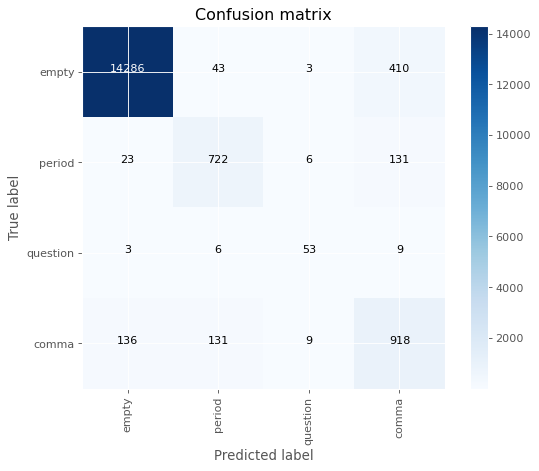

16 0.7485343002752765
              precision    recall  f1-score   support

       empty      0.989     0.969     0.979     14757
      period      0.800     0.819     0.809       883
    question      0.771     0.761     0.766        71
       comma      0.623     0.770     0.689      1194

    accuracy                          0.946     16905
   macro avg      0.796     0.829     0.811     16905
weighted avg      0.952     0.946     0.948     16905

2020-11-18 22:49:35,110 INFO      Macro precision is: 0.7958688073874898
2020-11-18 22:49:35,114 INFO      Macro recall is 0.8294343732671932
2020-11-18 22:49:35,118 INFO      Macro f-score is 0.810670191053366
2020-11-18 22:49:35,136 INFO      AUC is: 0.9617039653323004
2020-11-18 22:49:35,294 INFO      Plotting confusion matrix without normalization


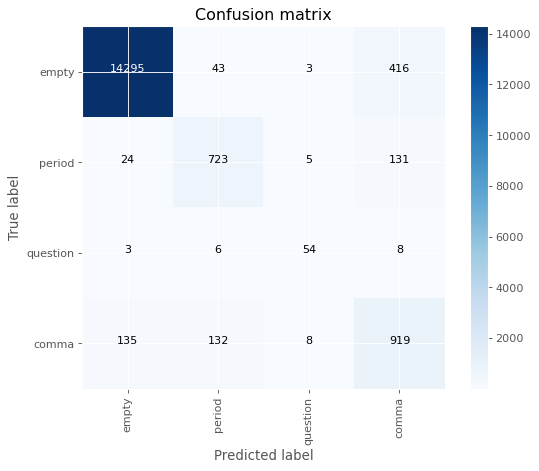

32 0.7546801287708192
              precision    recall  f1-score   support

       empty      0.989     0.969     0.979     14757
      period      0.798     0.813     0.805       883
    question      0.754     0.732     0.743        71
       comma      0.621     0.770     0.687      1194

    accuracy                          0.946     16905
   macro avg      0.790     0.821     0.804     16905
weighted avg      0.952     0.946     0.948     16905

2020-11-18 22:49:35,470 INFO      Macro precision is: 0.7903024170196519
2020-11-18 22:49:35,474 INFO      Macro recall is 0.820976491206995
2020-11-18 22:49:35,478 INFO      Macro f-score is 0.8035687413857338
2020-11-18 22:49:35,497 INFO      AUC is: 0.9615147308317068
2020-11-18 22:49:35,537 INFO      Plotting confusion matrix without normalization


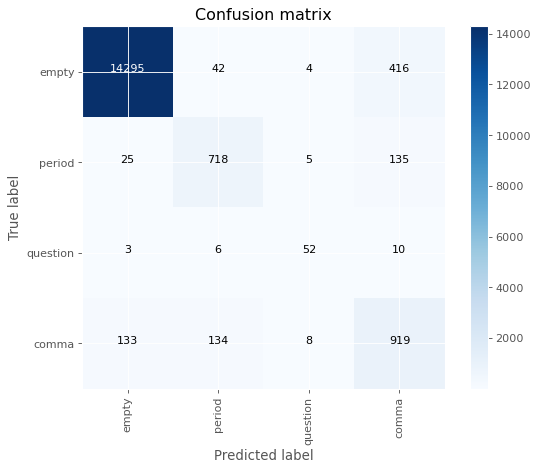

64 0.7452003624916504
              precision    recall  f1-score   support

       empty      0.989     0.968     0.978     14807
      period      0.790     0.807     0.799       887
    question      0.739     0.718     0.729        71
       comma      0.616     0.762     0.681      1197

    accuracy                          0.944     16962
   macro avg      0.783     0.814     0.797     16962
weighted avg      0.951     0.944     0.947     16962

2020-11-18 22:49:35,707 INFO      Macro precision is: 0.7834435012350123
2020-11-18 22:49:35,710 INFO      Macro recall is 0.8139727041866789
2020-11-18 22:49:35,714 INFO      Macro f-score is 0.7966859194737044
2020-11-18 22:49:35,732 INFO      AUC is: 0.9599263936390714
2020-11-18 22:49:35,773 INFO      Plotting confusion matrix without normalization


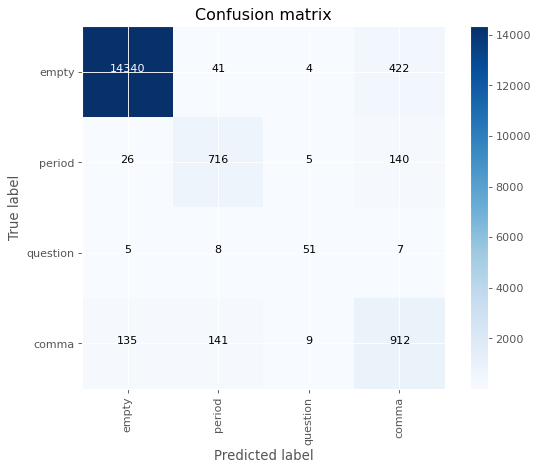

128 0.7361127307580343
              precision    recall  f1-score   support

       empty      0.989     0.969     0.979     14912
      period      0.789     0.828     0.808       893
    question      0.750     0.718     0.734        71
       comma      0.620     0.755     0.681      1203

    accuracy                          0.945     17079
   macro avg      0.787     0.817     0.800     17079
weighted avg      0.951     0.945     0.948     17079

2020-11-18 22:49:35,940 INFO      Macro precision is: 0.7868859495904128
2020-11-18 22:49:35,944 INFO      Macro recall is 0.8173132621854269
2020-11-18 22:49:35,948 INFO      Macro f-score is 0.8002256496785792
2020-11-18 22:49:35,967 INFO      AUC is: 0.9600644007923131
2020-11-18 22:49:36,009 INFO      Plotting confusion matrix without normalization


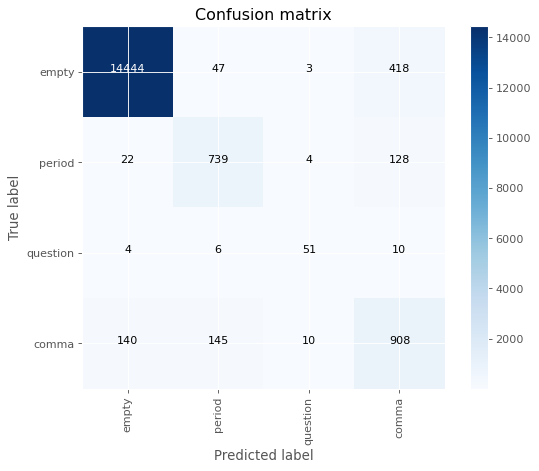

256 0.7407927028345423
              precision    recall  f1-score   support

       empty      0.988     0.967     0.977     14912
      period      0.790     0.817     0.804       893
    question      0.768     0.746     0.757        71
       comma      0.602     0.747     0.667      1203

    accuracy                          0.942     17079
   macro avg      0.787     0.819     0.801     17079
weighted avg      0.949     0.942     0.945     17079

2020-11-18 22:49:36,175 INFO      Macro precision is: 0.7869919716567015
2020-11-18 22:49:36,179 INFO      Macro recall is 0.8194458789872897
2020-11-18 22:49:36,182 INFO      Macro f-score is 0.8011415111456843
2020-11-18 22:49:36,201 INFO      AUC is: 0.9575462267760978
2020-11-18 22:49:36,242 INFO      Plotting confusion matrix without normalization


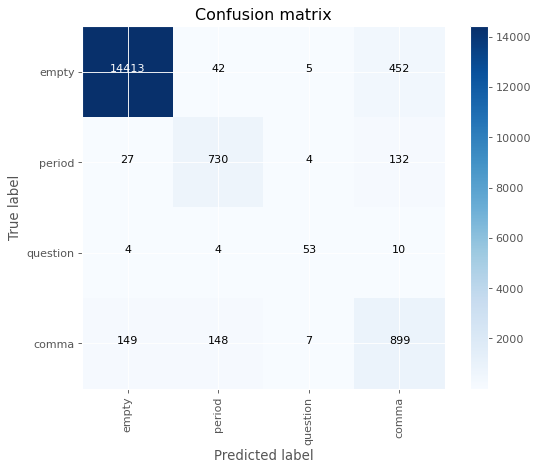

512 0.7425263644061871


In [143]:
# config.trainer.show_confusion_matrix = True
f_scores = []
reports = []
pred_num = 1
while pred_num <= 512:
    ps = combine(pred_num)
    _targets = np.array(all_valid_target[:ps.shape[0]])
    
    ps = ps[_targets != -1]
    _targets = _targets[_targets != -1]

    report = get_eval_metrics(_targets, ps, config)
    reports.append(report)
    strict_f_score = get_strict_f_score(report)
#     print(pred_num, strict_f_score)
    f_scores.append(strict_f_score)
    pred_num *= 2

with open(f'reports/report_{model_name}_{model_type}.pkl', 'wb') as f:
    pickle.dump(reports, f)

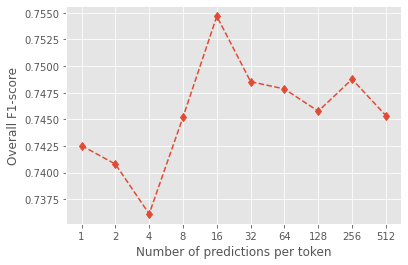

In [145]:
plt.style.use('ggplot')
# plt.title('Multiple predictions')
plt.ylabel('Overall F1-score')
plt.xlabel('Number of predictions per token')
plt.xticks(np.arange(int(np.log2(512))+1), [str(2**i) for i in range(0, int(np.log2(512))+1)])
plt.plot(f_scores[::-1], '--d')
plt.savefig(f'imgs/valid_{model_name}_multiple_predictions_{model_type}.svg')
plt.show()